In [2]:
from __future__ import print_function
import csv, json, datetime
import time
import nucleus_api
from nucleus_api.rest import ApiException
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

# Determine if in Jupyter notebook or not

try:
    ip = get_ipython()
    running_notebook = True
except NameError:
    running_notebook = False

if running_notebook:
    print('Running example in Jupyter Notebook')
else:
    print('Running example in script mode')

Running example in Jupyter Notebook


# Configure API host and key and create new API instance

In [4]:
configuration = nucleus_api.Configuration()
configuration.host = 'UPDATE-WITH-API-HOST'
configuration.api_key['x-api-key'] = 'UPDATE-WITH-API-KEY'

# Create API instance
api_instance = nucleus_api.NucleusApi(nucleus_api.ApiClient(configuration))


# Helper functions

In [5]:
# Plot topic historical analysis
def topic_charts_historical(historical_metrics, selected_topics, show_sentiment_consensus):

    # Charts of Strength, Sentiment, Consensus for each of the topics
    current_max_strength = 0
    current_max_sent = 0
    current_max_cons = 0
    for i in selected_topics:
        if np.nanmax(np.abs(historical_metrics[i]['strength'])) > current_max_strength:
            current_max_strength = np.nanmax(np.abs(historical_metrics[i]['strength']))
        if np.nanmax(np.abs(historical_metrics[i]['sentiment'])) > current_max_sent:
            current_max_sent = np.nanmax(np.abs(historical_metrics[i]['sentiment']))
        if np.nanmax(np.abs(historical_metrics[i]['consensus'])) > current_max_cons:
            current_max_cons = np.nanmax(np.abs(historical_metrics[i]['consensus']))

    if show_sentiment_consensus == True:
        plt.rcParams['figure.figsize'] = [12, 18*len(selected_topics)]
        fig = plt.figure() 
        for i in selected_topics:
            current_ax = 'ax' + str(selected_topics.index(i) + 1)
            if current_ax == 'ax1':
                current_ax = plt.subplot(3*len(selected_topics), 1, 1 + 3*selected_topics.index(i))
                ax1 = plt.subplot(3*len(selected_topics), 1, 1 + 3*selected_topics.index(i))
            else:
                current_ax = plt.subplot(3*len(selected_topics), 1, 1 + 3*selected_topics.index(i), sharex=ax1)

            # 3 subplots, one per strength, sentiment, consensus
            current_ax.set_ylim([0, 1.05*current_max_strength])
            current_ax.plot('time_stamps', 'strength', data=historical_metrics[i], color='blue')
            plt.ylabel('Prevalence', fontsize=14, fontweight="bold")
            plt.title(historical_metrics[i]['topic'], fontsize=14, fontweight="bold")

            current_axSent = plt.subplot(3*len(selected_topics), 1, 1 + 3*selected_topics.index(i) + 1, sharex=ax1)
            current_axSent.set_ylim([-1.05*current_max_sent, 1.05*current_max_sent])
            current_axSent.plot('time_stamps', 'sentiment', data=historical_metrics[i], color='green')
            plt.ylabel('Sentiment', fontsize=14, fontweight="bold")

            current_axCons = plt.subplot(3*len(selected_topics), 1, 1 + 3*selected_topics.index(i) + 2, sharex=ax1)
            current_axCons.set_ylim([0, 1.05*current_max_cons])
            current_axCons.plot('time_stamps', 'consensus', data=historical_metrics[i], color='red')
            plt.ylabel('Consensus', fontsize=14, fontweight="bold")

        fig.autofmt_xdate(rotation=90)
    else:
        plt.rcParams['figure.figsize'] = [12, 6*len(selected_topics)]
        fig = plt.figure()
        for i in selected_topics:
            current_ax = 'ax' + str(selected_topics.index(i) + 1)
            if current_ax == 'ax1':
                current_ax = plt.subplot(len(selected_topics), 1, selected_topics.index(i) + 1)
                ax1 = plt.subplot(len(selected_topics), 1, selected_topics.index(i) + 1)
            else:
                current_ax = plt.subplot(len(selected_topics), 1, selected_topics.index(i) + 1, sharex=ax1)
            current_ax.set_ylim([0, 1.05*current_max_strength])
            current_ax.plot('time_stamps', 'strength', data=historical_metrics[i], color='blue')
            plt.ylabel('Prevalence', fontsize=14, fontweight="bold")        
            plt.title(historical_metrics[i]['topic'], fontsize=14, fontweight="bold")
        fig.autofmt_xdate(rotation=90)
        
    return 0


# Dataset APIs

## Append file from local drive to dataset

In [6]:
print('--------- Append file from local drive to dataset -----------')
file = 'quarles20181109a.pdf'         # file | 
dataset = 'dataset_test'              # str | Destination dataset where the file will be inserted.
metadata = {"time": "1/2/2018", 
            "author": "Test Author"}  # Optional json containing additional document metadata

try:
    api_instance.post_upload_file(file, dataset, metadata=metadata)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_upload_file: %s\n" % e)

print(file, 'has been added to dataset', dataset)
print('-------------------------------------------------------------')



--------- Append file from local drive to dataset -----------
quarles20181109a.pdf has been added to dataset dataset_test
-------------------------------------------------------------


## Append file from URL to dataset

In [8]:
print('------------ Append file from URL to dataset ---------------')

dataset = dataset
file_url = 'https://www.federalreserve.gov/newsevents/speech/files/quarles20181109a.pdf'
payload = nucleus_api.UploadURLModel(
                dataset=dataset,
                file_url=file_url
            ) # UploadURLModel | 

try:
    api_response = api_instance.post_upload_url(payload)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_upload_url: %s\n" % e)
    
#pprint(api_response)   # raw API response
print(file_url, 'has been added to dataset', dataset)
print('-------------------------------------------------------------')

------------ Append file from URL to dataset ---------------
https://www.federalreserve.gov/newsevents/speech/files/quarles20181109a.pdf has been added to dataset dataset_test
-------------------------------------------------------------


## Append json from csv to dataset

In [13]:
print('----------- Append json from CSV to dataset -----------------')
# add documents to dataset
csv_file = 'trump-tweets-100.csv'
dataset = dataset   

doc_cnt = 0
with open(csv_file, encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if doc_cnt < 10:
            payload = nucleus_api.Appendjsonparams(dataset=dataset, 
                                                  language='english', 
                                                  document={'time'   : row['time'],
                                                            'title'  : row['title'],
                                                            'content': row['content'],
                                                            'author' : row['author']}
                                                 )

            try:
                api_response = api_instance.post_append_json_to_dataset(payload)
            except ApiException as e:
                print("Exception when calling DatasetsApi->post_append_json_to_dataset: %s\n" % e)
        
        doc_cnt = doc_cnt + 1
        
print('Dataset', dataset, 'now has', api_response.num_documents, 'documents.')
print('-------------------------------------------------------------')

----------- Append json from CSV to dataset -----------------
Dataset jim_wu_sumup_aidd1544055715114 now has 10 documents.
-------------------------------------------------------------


## List available datasets

In [14]:
print('---------------- List available datasets ---------------------')
try:
    api_response = api_instance.get_list_datasets()
except ApiException as e:
    print("Exception when calling DatasetsApi->get_list_datasets: %s\n" % e)

list_datasets = api_response.to_dict()['list_datasets']

print(len(list_datasets), 'datasets in the database:')
for ds in list_datasets:
    print('    ', ds)

    
print('-------------------------------------------------------------')

---------------- List available datasets ---------------------
2 datasets in the database:
     dataset_test
     jim_wu_sumup_aidd1544055715114
-------------------------------------------------------------


## Get dataset information

In [15]:
print('--------------- Get dataset information -------------------')
dataset = dataset # str | Dataset name.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. (optional)
metadata_selection = '' # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
time_period = '' # str | Time period selection (optional)

try:
    api_response = api_instance.get_dataset_info(
        dataset, 
        query=query, 
        metadata_selection=metadata_selection, 
        time_period=time_period)
except ApiException as e:
    print("Exception when calling DatasetsApi->get_dataset_info: %s\n" % e)

print('Information about dataset', dataset)
print('    Language:', api_response.detected_language)
print('    Number of documents:', api_response.num_documents)
print('    Time range:', datetime.datetime.fromtimestamp(float(api_response.time_range[0])),
             'to', datetime.datetime.fromtimestamp(float(api_response.time_range[1])))

#pprint(api_response) # raw API response
print('-------------------------------------------------------------')

--------------- Get dataset information -------------------
Information about dataset jim_wu_sumup_aidd1544055715114
    Language: en
    Number of documents: 10
    Time range: 2018-08-18 01:47:00 to 2018-08-18 19:39:00
-------------------------------------------------------------


## Delete document

In [17]:
print('--------------------- Delete document -----------------------')
dataset = dataset
docid = '1'
payload = nucleus_api.Deletedocumentmodel(dataset=dataset,
                                             docid=docid) # Deletedocumentmodel | 

try:
    api_response = api_instance.post_delete_document(payload)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_delete_document: %s\n" % e)


print('Document', docid, 'from dataset', dataset, 'has been deleted.')
# print(api_response)     # raw API response
print('-------------------------------------------------------------')

--------------------- Delete document -----------------------
Document 1 from dataset jim_wu_sumup_aidd1544055715114 has been deleted.
-------------------------------------------------------------


## Delete dataset

In [19]:
print('--------------------- Delete dataset ------------------------')

dataset = dataset  
payload = nucleus_api.Deletedatasetmodel(dataset=dataset) # Deletedatasetmodel | 

try:
    api_response = api_instance.post_delete_dataset(payload)
    pprint(api_response)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_delete_dataset: %s\n" % e)
    
# List datasets again to check if the specified dataset has been deleted
try:
    api_response = api_instance.get_list_datasets()
    pprint(api_response)
except ApiException as e:
    print("Exception when calling DatasetsApi->get_list_datasets: %s\n" % e)
    
print('-------------------------------------------------------------')

--------------------- Delete dataset ------------------------
{'success': 'Dataset deleted'}
{'list_datasets': ['dataset_test']}
-------------------------------------------------------------


## Create a full dataset for testing other APIs

In [21]:
print('--------- Create a full dataset for testing other APIs ---------')
# add documents to dataset
csv_file = 'trump-tweets-100.csv'
dataset = 'trump_tweets'   

with open(csv_file, encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        payload = nucleus_api.Appendjsonparams(dataset=dataset, 
                                                  language='english', 
                                                  document={'time'   : row['time'],
                                                            'title'  : row['title'],
                                                            'content': row['content'],
                                                            'author' : row['author']}
                                                 )

        try:
            response = api_instance.post_append_json_to_dataset(payload)
        except ApiException as e:
            print("Exception when calling DatasetsApi->post_append_json_to_dataset: %s\n" % e)
            
print('Dataset', dataset, 'now has', response.num_documents, 'documents.')
print('-------------------------------------------------------------')

--------- Create a full dataset for testing other APIs ---------
Dataset trump_tweets now has 100 documents.
-------------------------------------------------------------


# Topic APIs

## Get list of topics from dataset

In [22]:
print('------------- Get list of topics from dataset --------------')
dataset = dataset
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
metadata_selection ="" # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
time_period =""# str | Time period selection (optional)

try:
    api_response = api_instance.get_topic_api(
        dataset,                                
        query=query,                   
        custom_stop_words=custom_stop_words,     
        num_topics=num_topics,
        metadata_selection=metadata_selection,
        time_period=time_period)
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_api: %s\n" % e)
    
#print(api_response)
i = 1
for res in api_response.results:
    print('Topic', i, 'keywords:')
    print('    Keywords:', res.topic)
    keywords_weight_str = ";".join(str(x) for x in res.keywords_weight)
    print('    Keyword weights:', keywords_weight_str)
    print('    Strength:', res.strength)
    doc_topic_exposure_sel = []  # list of non-zero doc_topic_exposure
    doc_id_sel = []        # list of doc ids matching doc_topic_exposure_sel
    for j in range(len(res.doc_topic_exposure)):
        doc_topic_exp = float(res.doc_topic_exposure[j])
        if doc_topic_exp != 0:
            doc_topic_exposure_sel.append(doc_topic_exp)
            doc_id_sel.append(res.doc_id[j])
    
    doc_id_sel_str = ' '.join(str(x) for x in doc_id_sel)
    doc_topic_exposure_sel_str = ' '.join(str(x) for x in doc_topic_exposure_sel)
    print('    Document IDs:', doc_id_sel_str)
    print('    Document exposures:', doc_topic_exposure_sel_str)

    print('---------------')
    i = i + 1
    
print('-------------------------------------------------------------')

------------- Get list of topics from dataset --------------
Topic 1 keywords:
    Keywords: america great;great great;andrew cuomo;total meltdown;great believe;governor highest;cuomo total;believe governor
    Keyword weights: 0.14795797393756516;0.16695785166789107;0.14904268327507322;0.10720829822389409;0.10720829822389409;0.10720829822389409;0.10720829822389409;0.10720829822389409
    Strength: 0.17141232407831908
    Document IDs: 16 17 18 24 44 45
    Document exposures: 0.13842219371178488 0.0804584723966716 0.07557757475759962 0.09427887714883187 0.312912509996506 0.2983503719886059
---------------
Topic 2 keywords:
    Keywords: illegal aliens;united permission;permission illegal;legally chuck;left haywire;enter united;chuck schumer;aliens illegal
    Keyword weights: 0.1111111111111111;0.1111111111111111;0.1111111111111111;0.1111111111111111;0.1111111111111111;0.1111111111111111;0.1111111111111111;0.2222222222222222
    Strength: 0.12288376055244343
    Document IDs: 57 63
  

## Get topic summary

In [23]:
print('------------------- Get topic summary -----------------------')
dataset = dataset # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
metadata_selection ="" # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
summary_length = 6 # int | The maximum number of bullet points a user wants to see in each topic summary. (optional) (default to 6)
context_amount = 0 # int | The number of sentences surrounding key summary sentences in the documents that they come from. (optional) (default to 0)
num_docs = 20 # int | The maximum number of key documents to use for summarization. (optional) (default to 20)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_topic_summary_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords,
        metadata_selection=metadata_selection,
        summary_length=summary_length, 
        context_amount=context_amount, 
        num_docs=num_docs)
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_summary_api: %s\n" % e)

i = 1
for res in api_response.results:
    print('Topic', i, 'summary:')
    print('    Keywords:', res.topic)
    for j in range(len(res.summary)):
        print('    Document ID:', res.summary[j].sourceid)
        print('        Title:', res.summary[j].title)
        print('        Sentences:', res.summary[j].sentences)
        print('        Author:', res.summary[j].attribute.author)
        print('        Source:', res.summary[j].attribute.source)
        print('        Time:', datetime.datetime.fromtimestamp(float(res.summary[j].attribute.time)))

        #print(type(res.summary[j].attribute))
        
    print('---------------')
    i = i + 1
    
    
#pprint(api_response)  # raw API response
print('-------------------------------------------------------------')



------------------- Get topic summary -----------------------
Topic 1 summary:
    Keywords: america great;great great;andrew cuomo;total meltdown;great believe;governor highest;cuomo total;believe governor
    Document ID: 16
        Title: D_Trump2018_8_17_19_25
        Sentences: ["Which is worse Hightax Andrew Cuomo's statement “WE’RE NOT GOING TO MAKE AMERICA GREAT AGAIN IT WAS NEVER THAT GREAT” or Hillary Clinton’s “DEPLORABLES” statement..."]
        Author: D_Trump16
        Source: None
        Time: 2018-08-17 19:25:00
    Document ID: 24
        Title: D_Trump2018_8_17_11_44
        Sentences: ['How does a politician Cuomo known for pushing people and businesses out of his state not to mention having the highest taxes in the U.S. survive making the statement WE’RE NOT GOING TO MAKE AMERICA GREAT AGAIN IT WAS NEVER THAT GREAT?']
        Author: D_Trump24
        Source: None
        Time: 2018-08-17 11:44:00
    Document ID: 44
        Title: D_Trump2018_8_16_2_2
        Sent

## Get topic sentiment

In [24]:
print('---------------- Get topic sentiment ------------------------')
dataset = dataset # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_topic_sentiment_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords)
    
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_sentiment_api: %s\n" % e)

i = 1
for res in api_response.results:
    print('Topic', i, 'sentiment:')
    print('    Keywords:', res.topic)
    print('    Sentiment:', res.sentiment)
    print('    Strength:', res.strength)
    
    doc_id_str = ' '.join(str(x) for x in res.doc_id)
    doc_sentiment_str = ' '.join(str(x) for x in res.doc_sentiment)
    doc_score_str = ' '.join(str(x) for x in res.doc_score)
    print('    Doucment IDs:', doc_id_str)
    print('    Doucment Sentiments:', doc_sentiment_str)
    print('    Doucment Scores:', doc_score_str)
    
    print('---------------')
    i = i + 1
    
#pprint(api_response)
print('-------------------------------------------------------------')

---------------- Get topic sentiment ------------------------
Topic 1 sentiment:
    Keywords: america great;great great;andrew cuomo;total meltdown;great believe;governor highest;cuomo total;believe governor
    Sentiment: 0.41852550172486996
    Strength: 0.17141232407831908
    Doucment IDs: 16 17 18 24 44 45
    Doucment Sentiments: 0.2727272727272727 -0.2666666666666667 0.11764705882352941 0.45454545454545453 0.6 0.5454545454545454
    Doucment Scores: [0.1384221937117849, 0.08045847239667162, 0.07557757475759962, 0.09427887714883189, 0.31291250999650605, 0.2983503719886059]
---------------
Topic 2 sentiment:
    Keywords: illegal aliens;united permission;permission illegal;legally chuck;left haywire;enter united;chuck schumer;aliens illegal
    Sentiment: -0.46153846153846156
    Strength: 0.12288376055244343
    Doucment IDs: 57 63
    Doucment Sentiments: -0.46153846153846156 -0.46153846153846156
    Doucment Scores: [0.5, 0.5]
---------------
Topic 3 sentiment:
    Keywords: b

## Get topic consensus

In [25]:
print('---------------- Get topic consensus ------------------------')
dataset = dataset # str | Dataset name.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_topic_consensus_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords)
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_consensus_api: %s\n" % e)
    
i = 1
for res in api_response.results:
    print('Topic', i, 'consensus:')
    print('    Keywords:', res.topic)
    print('    Consensus:', res.consensus)
    print('    Strength:', res.strength)
    
    print('---------------')
    i = i + 1
    
#pprint(api_response) # raw API response
print('-------------------------------------------------------------')

---------------- Get topic consensus ------------------------
Topic 1 consensus:
    Keywords: america great;great great;andrew cuomo;total meltdown;great believe;governor highest;cuomo total;believe governor
    Consensus: 0.9195415276033284
    Strength: 0.17141232407831908
---------------
Topic 2 consensus:
    Keywords: illegal aliens;united permission;permission illegal;legally chuck;left haywire;enter united;chuck schumer;aliens illegal
    Consensus: 1.0
    Strength: 0.12288376055244343
---------------
Topic 3 consensus:
    Keywords: bruce ohr;wife nelly;ohr justice;justice department;fusion gps;christopher steele;fake dossier;disgraced christopher
    Consensus: 1.0
    Strength: 0.15241400065525243
---------------
Topic 4 consensus:
    Keywords: witch hunt;donald trump;frame donald;hillary clinton;rigged witch;jarrett foxandfriends;gregg jarrett;attorney witch
    Consensus: 0.9656666807371614
    Strength: 0.14379054726299764
---------------
Topic 5 consensus:
    Keywords

## Get topic historical analysis

------------ Get topic historical analysis ----------------
Plotting historical metrics data...


/Users/jimw/github/sumup/anser-dev/.eggs/matplotlib-3.0.1-py3.6-macosx-10.6-intel.egg/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


-------------------------------------------------------------


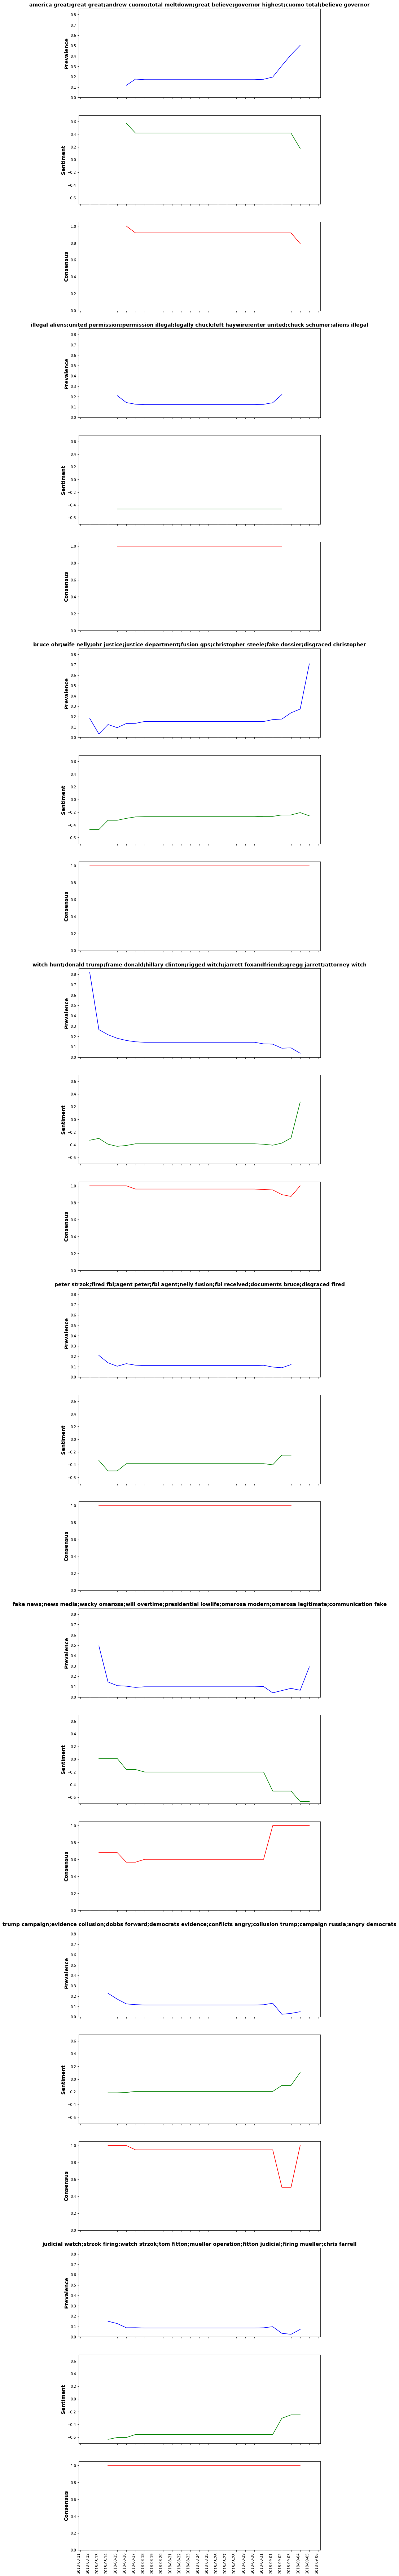

In [26]:
print('------------ Get topic historical analysis ----------------')

dataset = dataset   # str | Dataset name.
time_period = '6M'  # str | Time period selection (default to 1M)
update_period = 'd' # str | Frequency at which the historical anlaysis is performed (default to d)
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of stop words (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
metadata_selection = '' # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
inc_step = 1 # int | Number of increments of the udpate period in between two historical computations. (optional) (default to 1)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_topic_historical_analysis_api(
        dataset, 
        time_period, 
        update_period, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords, 
        metadata_selection=metadata_selection, 
        inc_step=inc_step, 
        excluded_docs=excluded_docs)
    
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_historical_analysis_api: %s\n" % e)

results = api_response.results

# chart the historical metrics when running in Jupyter Notebook
if running_notebook:
    print('Plotting historical metrics data...')
    historical_metrics = []
    for res in results:
        # conctruct a list of historical metrics dictionaries for charting
        historical_metrics.append({
            'topic'    : res.topic,
            'time_stamps' : np.array(res.time_stamps),
            'strength' : np.array(res.strength, dtype=np.float32),
            'consensus': np.array(res.consensus, dtype=np.float32), 
            'sentiment': np.array(res.sentiment, dtype=np.float32)})

    selected_topics = range(len(historical_metrics)) 
    topic_charts_historical(historical_metrics, selected_topics, True)
else:
    print('Printing historical metrics data...')
    print('NOTE: historical metrics data can be plotted when running the example in Jupyter Notebook')
    i = 1
    for res in results:
        print('Topic', i, res.topic)
        print('    Timestamps:', res.time_stamps)
        print('    Strength:', res.strength)
        print('    Consensus:', res.consensus)
        print('    Sentiment:', res.sentiment)
        print('----------------')
        i = i + 1
#pprint(api_response)
print('-------------------------------------------------------------')

## Get author connectivity

In [27]:
print('----------------- Get author connectivity -------------------')
dataset = dataset # str | Dataset name.
target_author = 'D_Trump16' # str | Name of the author to be analyzed.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Subject covered by the author, on which to focus the analysis of connectivity. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of words possibly used by the target author that are considered not information-bearing. (optional)
time_period = '12M' # str | Time period selection. Required. Valid values: "1M","3M","6M","12M","3Y","5Y"
metadata_selection = '' # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_author_connectivity_api(
        dataset, 
        target_author, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        time_period=time_period, 
        metadata_selection=metadata_selection, 
        excluded_docs=excluded_docs)
    
except ApiException as e:
    print("Exception when calling TopicsApi->get_author_connectivity_api: %s\n" % e)

res = api_response.results
print('Mainstream connections:')
for mc in res.mainstream_connection:
    print('    Topic:', mc.topic)
    print('    Authors:', " ".join(str(x) for x in mc.authors))
    
print('Niche connections:')
for nc in res.niche_connection:
    print('    Topic:', nc.topic)
    print('    Authors:', " ".join(str(x) for x in nc.authors))  
    
#pprint(api_response)   # raw API response
print('-------------------------------------------------------------')

----------------- Get author connectivity -------------------
Mainstream connections:
    Topic: hillary clinton;hightax andrew;deplorables statement
    Authors: D_Trump69
Niche connections:
    Topic: worse hightax;statement america;andrew cuomo
    Authors: D_Trump18
-------------------------------------------------------------


# Get topic delta

In [28]:
print('------------------- Get topic deltas -----------------------')
dataset = 'trump_tweets' 
#dataset = dataset # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = [""] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
metadata_selection ="" # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
time_start_t0 = '2018-08-12 00:00:00'
time_end_t0 = '2018-08-15 13:00:00'
time_start_t1 = '2018-08-16 00:00:00'
time_end_t1 = '2018-08-19 00:00:00'
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_topic_delta_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords,
        time_start_t0 = time_start_t0,
        time_end_t0 = time_end_t0,
        time_start_t1 = time_start_t1,
        time_end_t1 = time_end_t1,
        metadata_selection=metadata_selection)
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_delta_api: %s\n" % e)

i = 1
for res in api_response.results:
    print('Topic', i, 'changes in exposure:')
    print('    Keywords:', res.topic)
    print('    Document ID:', res.doc_id_t0, res.doc_id_t1)
    print('    Per Source Change in Exposure:', res.doc_topic_exposure_delta)
    print('---------------')
    i = i + 1
    
    
#pprint(api_response)  # raw API response
print('-------------------------------------------------------------')




------------------- Get topic deltas -----------------------
Topic 1 changes in exposure:
    Keywords: witch hunt;donald trump;hillary clinton;real attorney;hunt started;gregg jarrett;frame donald;attorney witch
    Document ID: ['62', '63', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '80', '81', '82', '83', '84', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'] ['2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '18', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47']
    Per Source Change in Exposure: ['-0.0', '-0.0', '-0.0', '-0.0', '-0.09360895849000755', '-0.0', '-0.6026105894779076', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.07223086867684234', '-0.08016192288338378', '-0.0', '-0.0', 

# Document APIs

## Get document information without content

In [29]:
dataset = dataset # str | Dataset name.
doc_titles = ['D_Trump2018_8_18_1_47']   # str | The title of the document to retrieve. Example: \" \"title 1\" \"  (optional)
doc_ids = ['11', '12', '20']      # int | The docid of the document to retrieve. Example: \"docid1\"  (optional)

try:
    api_response = api_instance.get_doc_info(dataset, doc_titles=doc_titles, doc_ids=doc_ids)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_info: %s\n" % e)
    
for res in api_response.results:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute.author)
    print('    Source:', res.attribute.source)
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute.time)))

    print('---------------')
    
    
#pprint(api_response)  # raw response from API server
print('-------------------------------------------------------------')

Document ID: 10
    Title: D_Trump2018_8_18_1_47
    Author: D_Trump10
    Source: None
    Time: 2018-08-18 01:47:00
---------------
Document ID: 11
    Title: D_Trump2018_8_18_1_46
    Author: D_Trump11
    Source: None
    Time: 2018-08-18 01:46:00
---------------
Document ID: 12
    Title: D_Trump2018_8_18_1_37
    Author: D_Trump12
    Source: None
    Time: 2018-08-18 01:37:00
---------------
Document ID: 20
    Title: D_Trump2018_8_17_12_38
    Author: D_Trump20
    Source: None
    Time: 2018-08-17 12:38:00
---------------
-------------------------------------------------------------


## Display document details

In [30]:
print('-------------------------------------------------------------')

dataset = dataset # str | Dataset name.
#doc_titles = ['D_Trump2018_8_18_1_47']   # str | The title of the document to retrieve. Example: \" \"title 1\" \"  (optional)
doc_ids = ['1']      # int | The docid of the document to retrieve. Example: \"docid1\"  (optional)

try:
    api_response = api_instance.get_doc_display(dataset, 
                                                    #doc_titles=doc_titles, 
                                                    doc_ids=doc_ids)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_display_api: %s\n" % e)

for res in api_response.results:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute.author)
    print('    Source:', res.attribute.source)
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute.time)))
    print('    Content', res.content)

    print('---------------')


#pprint(api_response) # raw response from API server
print('-------------------------------------------------------------')

-------------------------------------------------------------
Document ID: 1
    Title: D_Trump2018_8_18_19_39
    Author: D_Trump1
    Source: None
    Time: 2018-08-18 19:39:00
    Content 
---------------
-------------------------------------------------------------


## Get document recommendations

In [31]:
print('------------- Get document recommendations -----------------')

dataset = dataset # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # ERRORUNKNOWN | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_doc_recommend_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords)
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_recommend_api: %s\n" % e)
    
i = 1
for res in api_response.results:
    print('Document recommendations for topic', i, ':')
    print('    Keywords:', res.topic)

    j = 1
    for doc in res.recommendations:
        print('    Recommendation', j, ':')
        print('        Document ID:', doc.sourceid)
        print('        Title:', doc.title)
        print('        Attribute:', doc.attribute)
        print('        Author:', doc.attribute.author)
        print('        Source:', doc.attribute.source)
        print('        Time:', datetime.datetime.fromtimestamp(float(doc.attribute.time)))
        j = j + 1
    
    print('---------------')
    i = i + 1
    
#pprint(api_response)   # raw API response
print('-------------------------------------------------------------')

------------- Get document recommendations -----------------
Document recommendations for topic 1 :
    Keywords: america great;great great;andrew cuomo;total meltdown;great believe;governor highest;cuomo total;believe governor
    Recommendation 1 :
        Document ID: 16
        Title: D_Trump2018_8_17_19_25
        Attribute: {'author': 'D_Trump16', 'source': None, 'time': '1534559100.0'}
        Author: D_Trump16
        Source: None
        Time: 2018-08-17 19:25:00
    Recommendation 2 :
        Document ID: 17
        Title: D_Trump2018_8_17_14_17
        Attribute: {'author': 'D_Trump17', 'source': None, 'time': '1534540620.0'}
        Author: D_Trump17
        Source: None
        Time: 2018-08-17 14:17:00
    Recommendation 3 :
        Document ID: 18
        Title: D_Trump2018_8_17_14_10
        Attribute: {'author': 'D_Trump18', 'source': None, 'time': '1534540200.0'}
        Author: D_Trump18
        Source: None
        Time: 2018-08-17 14:10:00
    Recommendation 4 :
  

## Get document summary

In [32]:
print('------------------ Get document summary  --------------------')

dataset = dataset # str | Dataset name.
doc_title = 'D_Trump2018_8_15_15_4' # str | The title of the document to be summarized.
custom_stop_words = ["real","hillary"] # ERRORUNKNOWN | List of stop words. (optional)
summary_length = 6 # int | The maximum number of bullet points a user wants to see in the document summary. (optional) (default to 6)
context_amount = 0 # int | The number of sentences surrounding key summary sentences in the documents that they come from. (optional) (default to 0)

try:
    api_response = api_instance.get_doc_summary_api(
        dataset, 
        doc_title, 
        custom_stop_words=custom_stop_words, 
        summary_length=summary_length, 
        context_amount=context_amount)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_summary_api: %s\n" % e)
 
print('Document Summary')
print('    ID:', api_response.summary.sourceid)
print('    Title:', api_response.doc_title)
print('    Summary:', api_response.summary.sentences)

#pprint(api_response)   # raw API response
print('-------------------------------------------------------------')

------------------ Get document summary  --------------------
Document Summary
    ID: 50
    Title: D_Trump2018_8_15_15_4
    Summary: ['Our Country was built on Tariffs and Tariffs are now leading us to great new Trade Deals - as opposed to the horrible and unfair Trade Deals that I inherited as your President.', 'Other Countries should not be allowed to come in and steal the wealth of our great U.S.A. No longer!']
-------------------------------------------------------------
